In [1]:
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict

from portwine.strategies import StrategyBase
from portwine.backtester import Backtester
from portwine.loaders import EODHDMarketDataLoader
from portwine.analyzers import EquityDrawdownAnalyzer, MonteCarloAnalyzer, SeasonalityAnalyzer

class GlobalMarketRotationStrategy(StrategyBase):
    """
    Implements the 'Global Market Rotation Strategy' described in:
      "A Global Market Rotation Strategy With An Annual Performance Of 41.4% Since 2003"

    ETFs involved:
      1) MDY  (US mid-cap stocks)
      2) IEV  (Europe)
      3) EEM  (Emerging Markets)
      4) ILF  (Latin America)
      5) EPP  (Asia-Pacific ex-Japan)
      6) EDV  (Extended Duration Treasuries, used as 'risk-off' in market corrections)
      7) SHY  (Short-term Treasuries, used as a fallback 'cash' if EDV stops working)

    Core Logic (Monthly Rotation):
      • Once a month (near month-end or a chosen day), calculate a “score” (default: 3-month total return)
        for each of the 5 equity-region ETFs plus EDV. If, for some reason, EDV is not performing 
        or is not negatively correlated with equities, we can include SHY as a backup. 
      • Pick the top-ranked ETF and allocate 100% to it for the coming month.
      • Repeat each month.

    Simpler Variation:
      The paper says you can do well just by picking the best 3-month performer out of [MDY, IEV, EEM, ILF, EPP, EDV].
      Some traders also incorporate short-term Treasuries (SHY) if EDV fails to be a true safe haven.

    This example code:
      1) Rebalances monthly on the last trading day of each month.
      2) Ranks each ETF by its 3-month total return (63 trading days). 
      3) Optionally penalizes EDV for higher volatility (the paper suggests factoring in volatility),
         but here we keep it simple and rank purely by total return unless you choose otherwise.
      4) If EDV is the top pick, we invest in EDV. If for some reason EDV doesn’t have valid data
         (or you prefer correlation checks), you can skip or allow SHY as a fallback.

    Usage:
      strategy = GlobalMarketRotationStrategy(
          tickers=["MDY","IEV","EEM","ILF","EPP","EDV","SHY"]
      )
      results = backtester.run_backtest(strategy, benchmark_ticker="SPY")
    """

    def __init__(
        self,
        tickers,
        lookback_days=63,
        rebalance_on_last_day=True,
        f_vol=0.0,
    ):
        """
        Parameters
        ----------
        tickers : list of str
            The set of ETFs to rotate among. Typically:
              ["MDY","IEV","EEM","ILF","EPP","EDV","SHY"].
            Or omit "SHY" if you prefer just [MDY,IEV,EEM,ILF,EPP,EDV].
        lookback_days : int
            The approximate 3-month lookback window (63 trading days).
        rebalance_on_last_day : bool
            If True, rebalance on the *last* trading day each month. 
            If False, you might choose a different approach. 
        f_vol : float
            (Optional) If > 0, we reduce each ETF's score by a factor of volatility 
            (similar to a Sharpe-like ranking). 
            For example, score = 3mo_return / (vol^f_vol).
            The paper does something like a small penalty for EDV’s higher volatility.
        """
        super().__init__(tickers)
        self.lookback_days = lookback_days
        self.rebalance_on_last_day = rebalance_on_last_day
        self.f_vol = f_vol

        # Price history for each ticker
        self.price_history = {tkr: [] for tkr in tickers}

        # Current daily weights
        self.current_weights = {tkr: 0.0 for tkr in tickers}

    def step(self, current_date, daily_data):
        """
        Called each trading day. 
          1) Store today's close in rolling buffers.
          2) Check if it's the end of the month (or monthly rebal day).
          3) If yes, rank all tickers by 3-month total return (plus optional volatility penalty),
             pick the top, and set that ticker's weight=1.0, all others=0.
        Returns
        -------
        dict : { ticker : float weight, ... }
        """
        # 1) Update rolling price data
        self._update_price_history(daily_data)

        # 2) If it's our monthly rebalance day, do the rotation
        if self._is_monthly_rebalance_day(current_date):
            best_ticker, best_score = None, float('-inf')

            for tkr in self.tickers:
                score = self._compute_score(tkr)
                if score is not None and score > best_score:
                    best_score = score
                    best_ticker = tkr

            # If we found a valid best ticker
            if best_ticker is not None:
                for tkr in self.tickers:
                    self.current_weights[tkr] = 1.0 if tkr == best_ticker else 0.0

        return dict(self.current_weights)

    def _update_price_history(self, daily_data):
        """Append today's close for each ticker; keep a reasonable buffer."""
        max_keep = self.lookback_days * 2  # just some buffer
        for tkr in self.price_history:
            if tkr in daily_data and daily_data[tkr] is not None:
                self.price_history[tkr].append(daily_data[tkr]['close'])
            else:
                self.price_history[tkr].append(np.nan)

            if len(self.price_history[tkr]) > max_keep:
                self.price_history[tkr].pop(0)

    def _is_monthly_rebalance_day(self, date):
        """
        If rebalance_on_last_day=True => check if date is the last trading day of its month.
        Otherwise, you could define a different rule (like day-of-month == some day).
        """
        if not self.rebalance_on_last_day:
            # Example: Rebalance on day-of-month=1
            return (date.day == 1)
        # Else if it's the last day of the month
        # Use calendar.monthrange to find last day
        last_day = calendar.monthrange(date.year, date.month)[1]
        return (date.day == last_day)

    def _compute_score(self, ticker):
        """
        We compute 3-month total return for this ticker. Then optionally 
        incorporate a volatility penalty if self.f_vol>0. 
        If not enough data, return None.
        """
        hist = self.price_history[ticker]
        if len(hist) < (self.lookback_days + 1):
            return None  # not enough data

        # Grab the last (lookback_days+1) prices, ignoring any NaNs inside
        recent = hist[-(self.lookback_days + 1):]
        # Filter out NaNs
        clean = [p for p in recent if not np.isnan(p)]
        if len(clean) < (self.lookback_days + 1):
            return None  # missing data

        start_price = clean[0]
        end_price = clean[-1]
        if start_price < 1e-9:
            return None

        # 3-month total return
        total_ret = (end_price / start_price) - 1.0

        if self.f_vol <= 0.0:
            # Simple approach: just use total_ret as score
            return total_ret
        else:
            # If we want to penalize volatility in a Sharpe-like sense:
            # daily returns over the same window
            daily_r = np.diff(clean) / np.array(clean[:-1])
            vol = np.std(daily_r, ddof=1)
            if vol < 1e-9:
                return None

            # Score = total_ret / (vol^f_vol)
            return total_ret / (vol ** self.f_vol)


In [5]:
data_manager = EODHDMarketDataLoader('../../../Developer/Data/EODHD/us_sorted/US/')

backtester = Backtester(data_manager)

In [6]:
base_etfs = ["MDY", "IEV", "EEM", "ILF", "EPP", "EDV", "SHY"]

sector_etfs = ["XLP", "XLY", "XLF", "XLV", "XLK", "TLT", "SHY"]
broad_etfs = ["SPY", "QQQ", "IWM", "EFA", "EEM", "TLT", "SHV"]
commodity_etfs = ["GLD", "SLV", "USO", "DBA", "TLT", "SHY"]
stocks_basket = ["AAPL", "TSLA", "XOM", "JNJ", "TLT", "BIL"]
extended_sectors = ["XLF", "XLE", "XLK", "XLY", "XLP", "XLV", "XLI", "XLB", "XLU", "TLT", "SHY"]

Running backtest: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6289/6289 [00:01<00:00, 5740.41it/s]


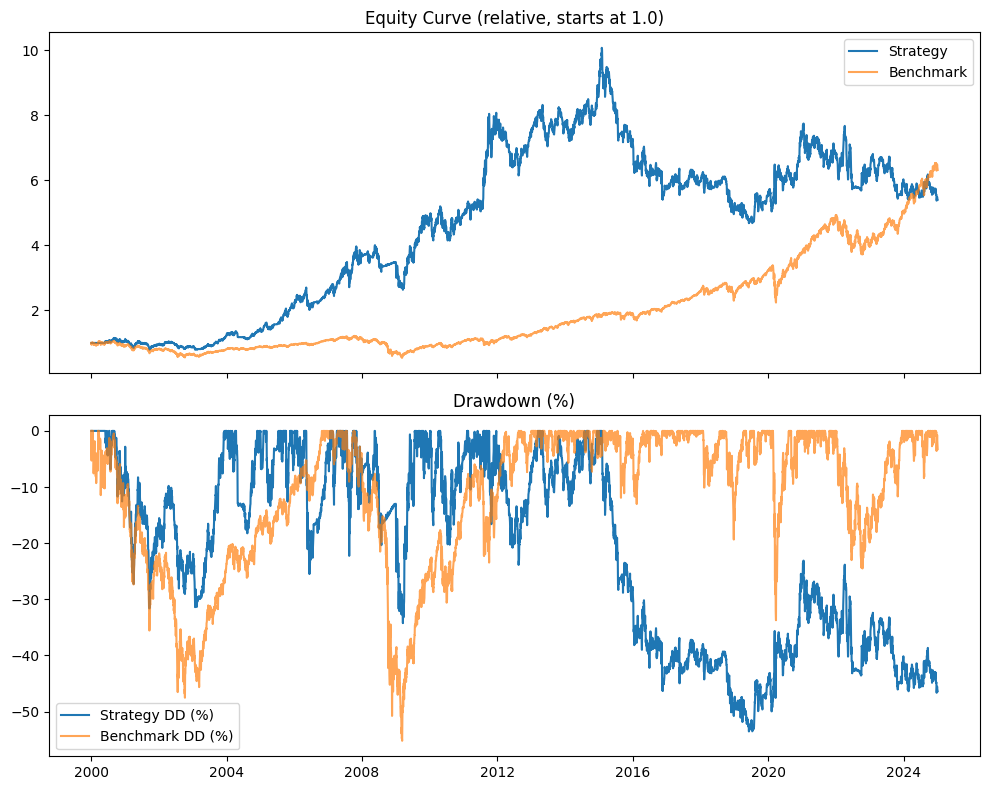

In [7]:
strategy = GlobalMarketRotationStrategy(
    tickers=base_etfs,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY", verbose=True)

EquityDrawdownAnalyzer().plot(results)

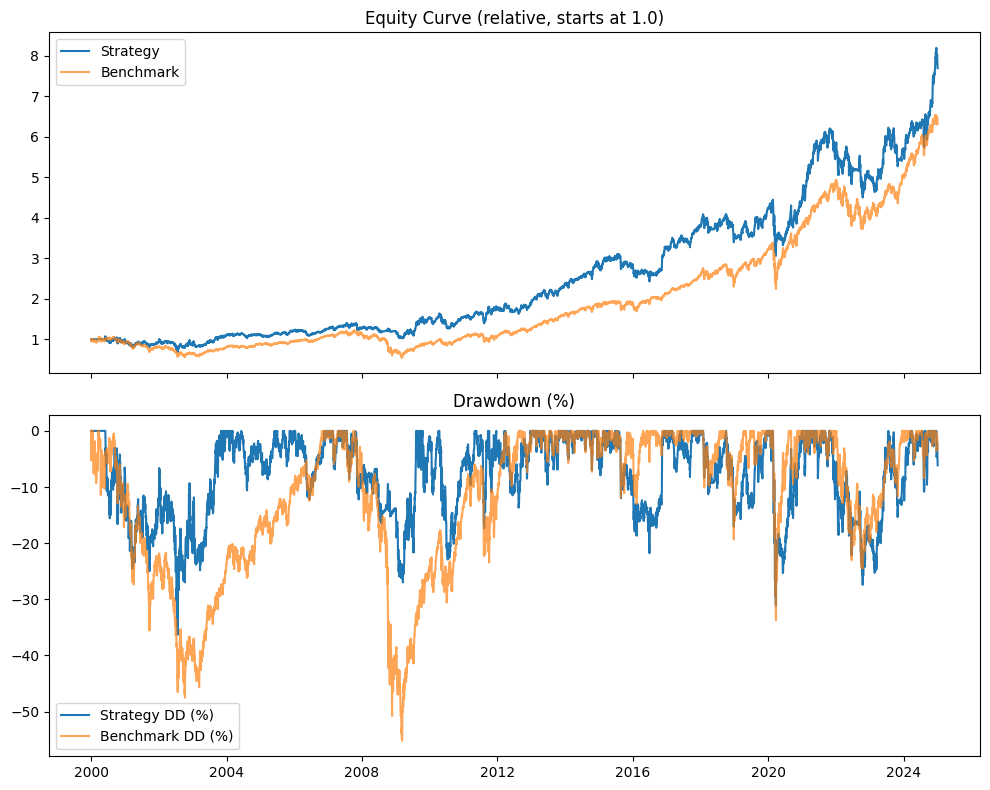

In [5]:
strategy = GlobalMarketRotationStrategy(
    tickers=sector_etfs,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY")

EquityDrawdownAnalyzer().plot(results)

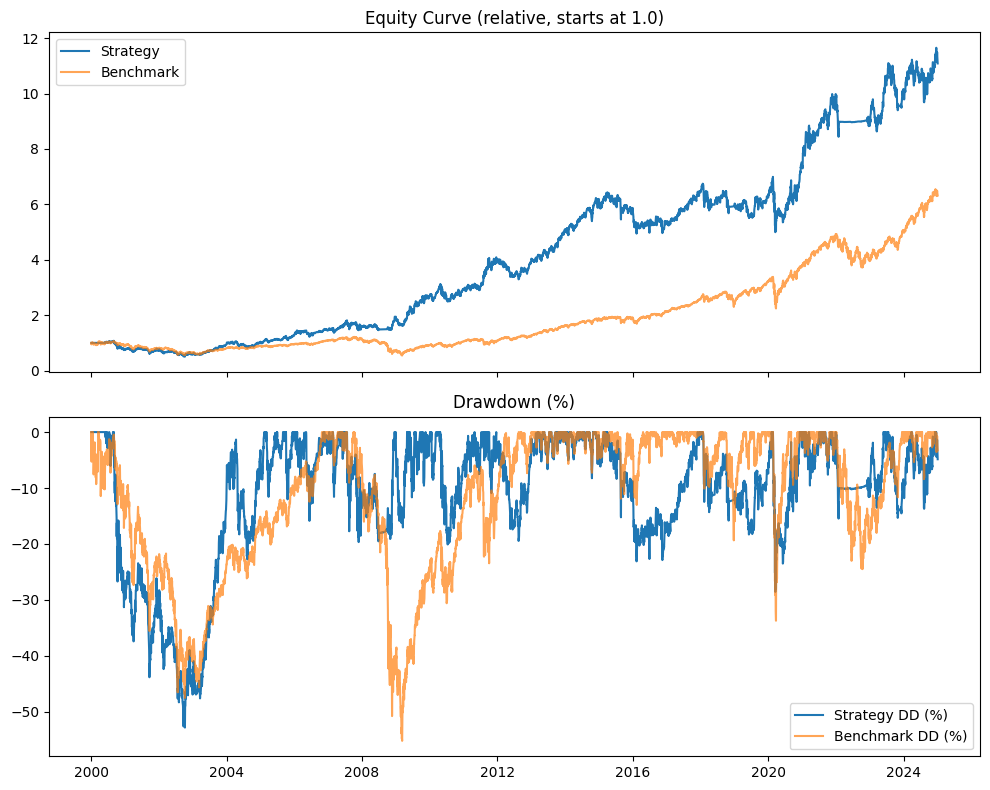

In [6]:
strategy = GlobalMarketRotationStrategy(
    tickers=broad_etfs,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY")

EquityDrawdownAnalyzer().plot(results)

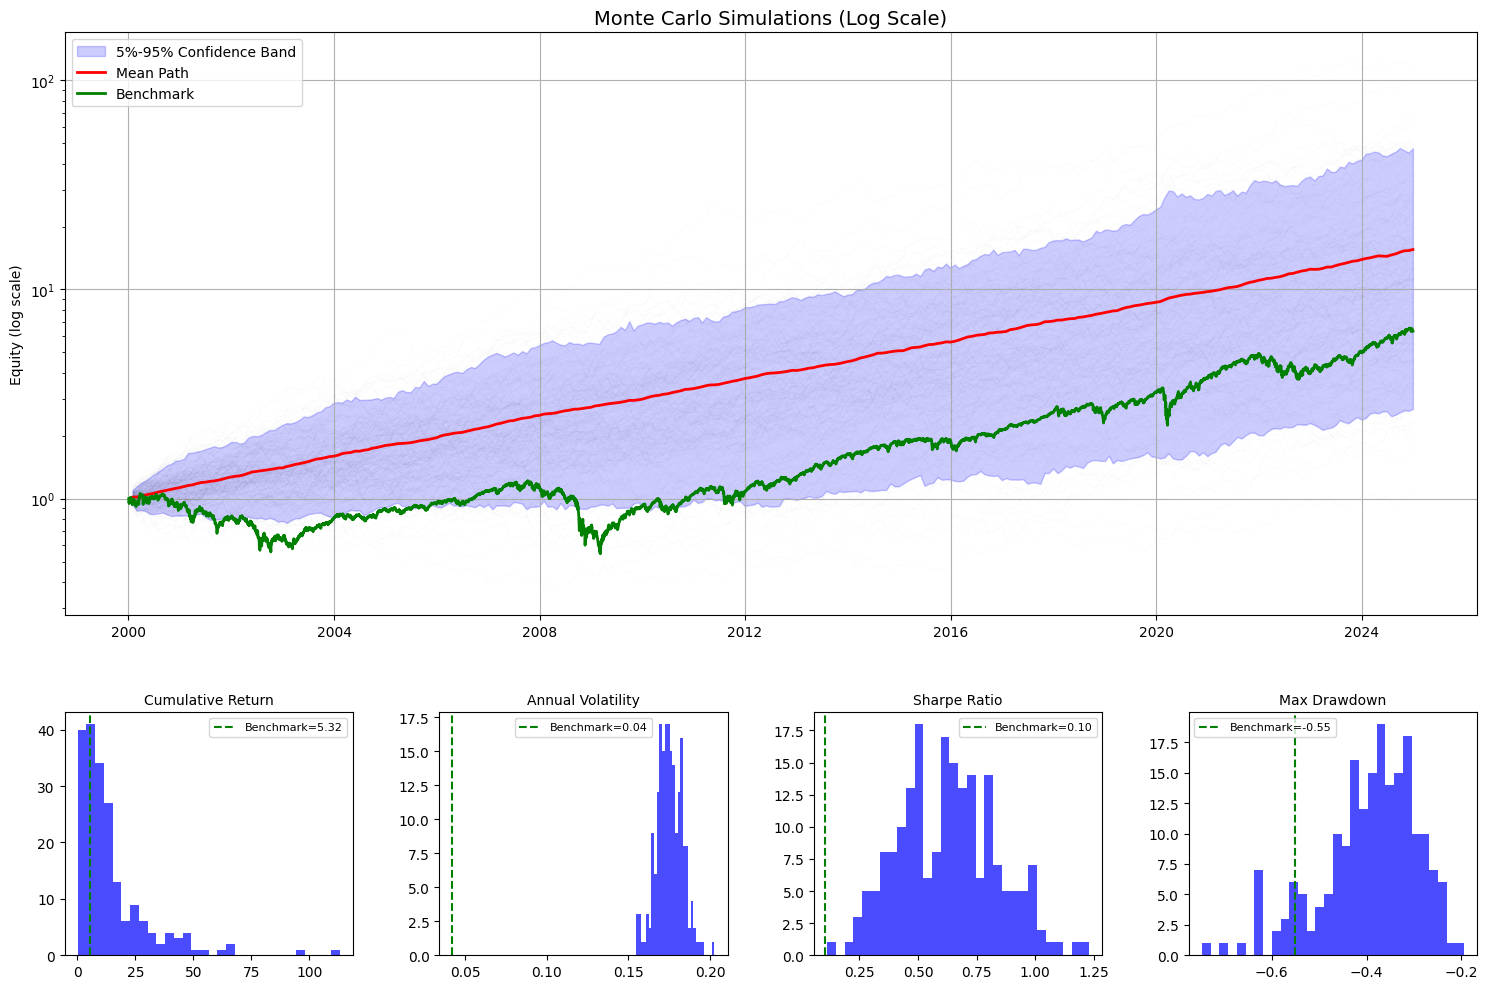

In [7]:
MonteCarloAnalyzer().plot(results)

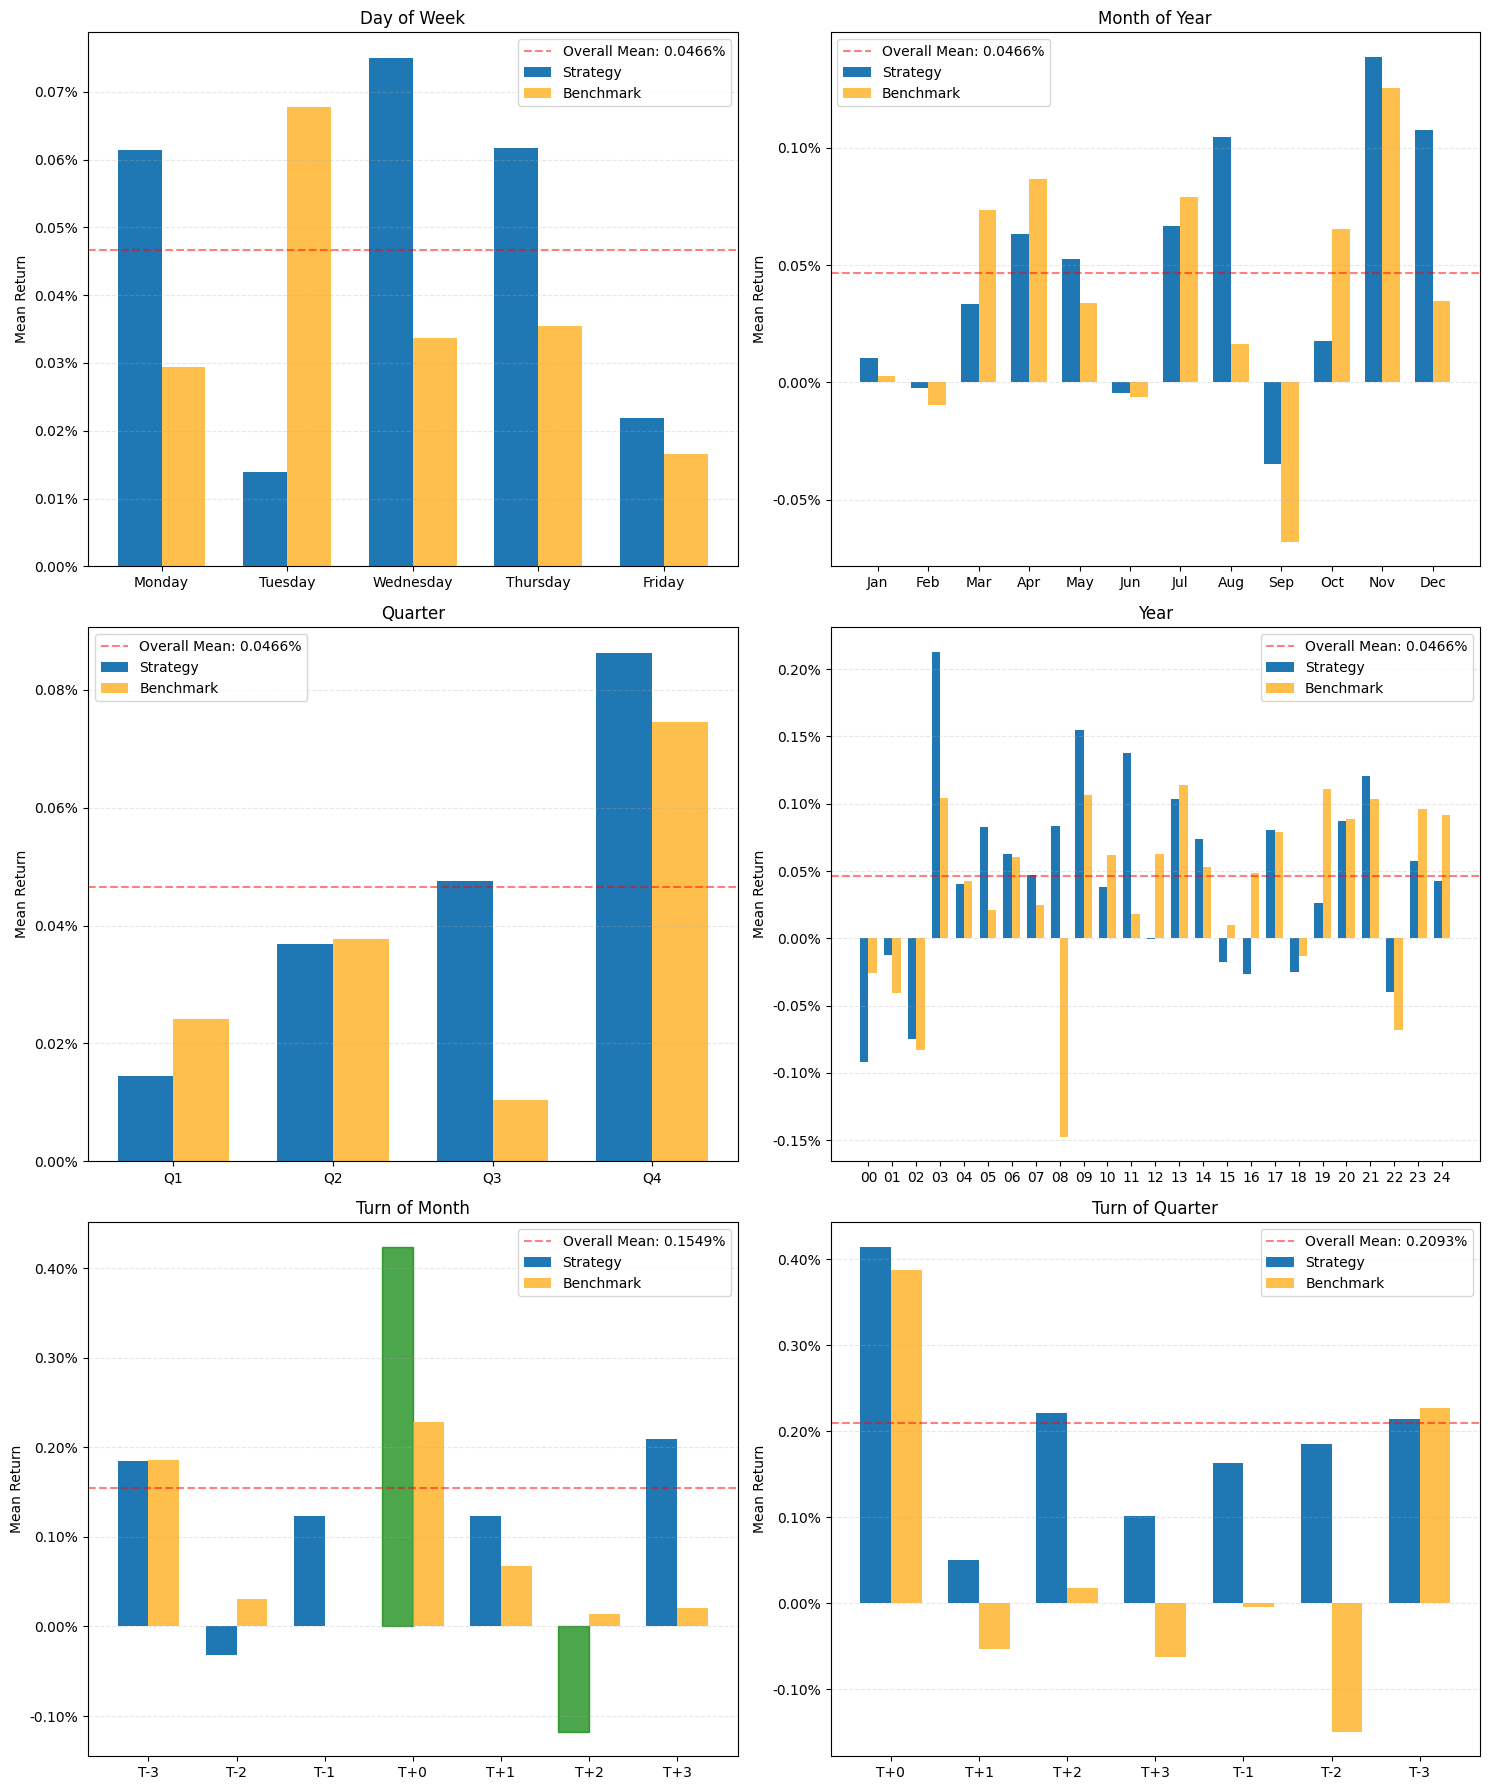

In [8]:
SeasonalityAnalyzer().plot(results)

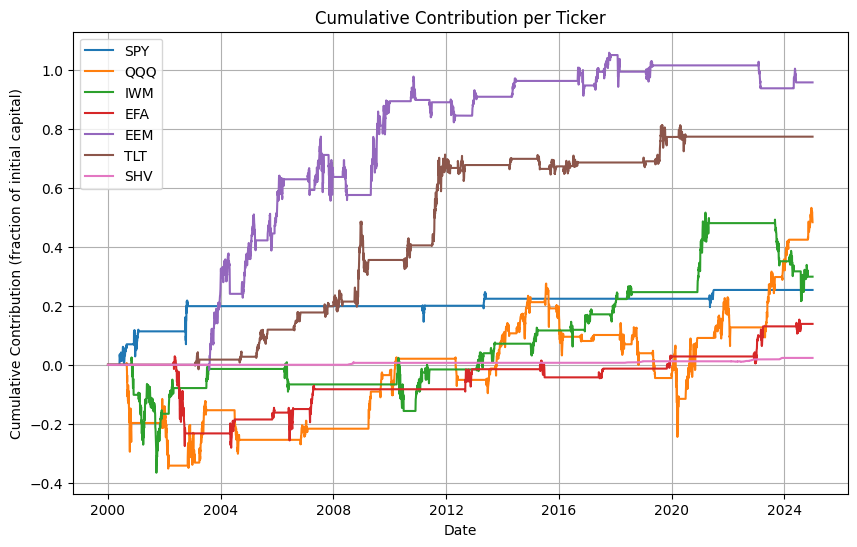

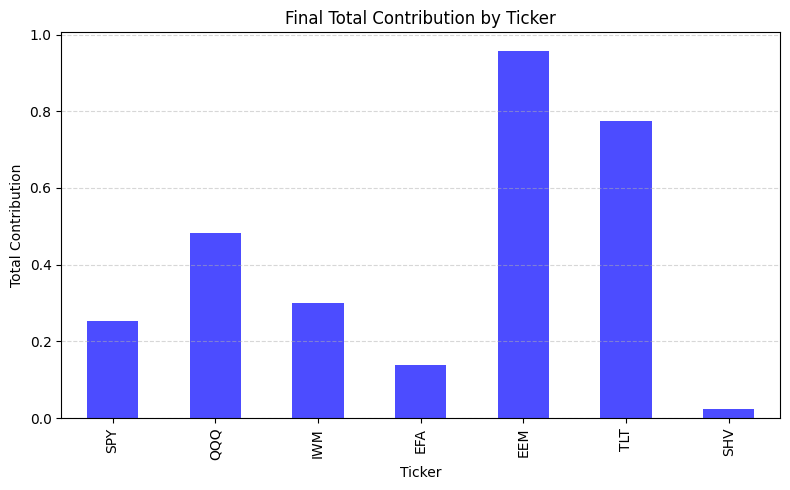

In [9]:
## Paid-subscriber Analyzer
PerformanceAttributionAnalyzer().plot(results)

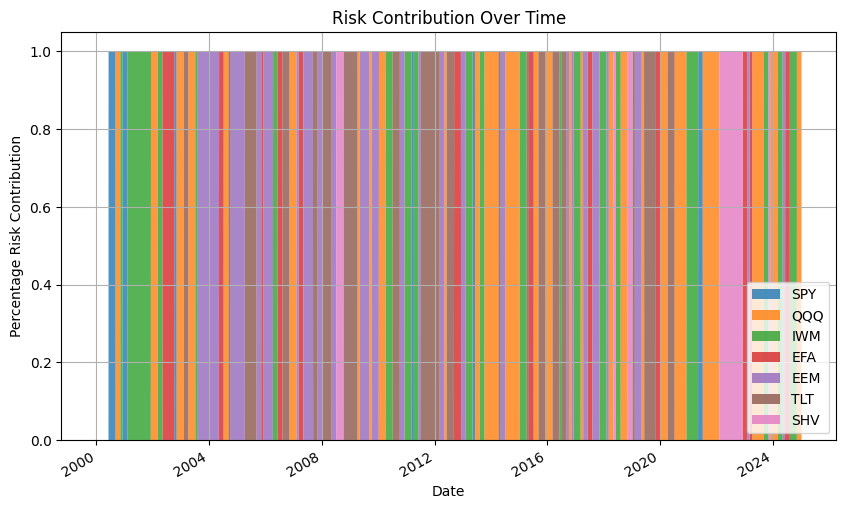

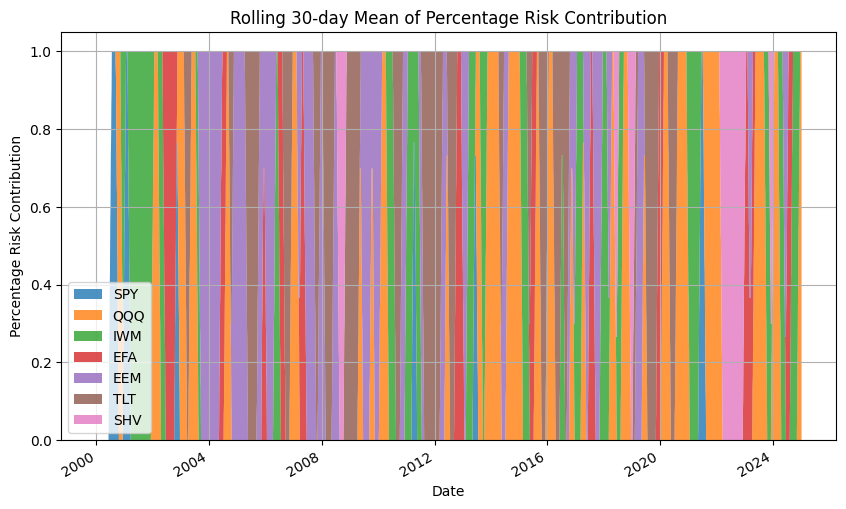

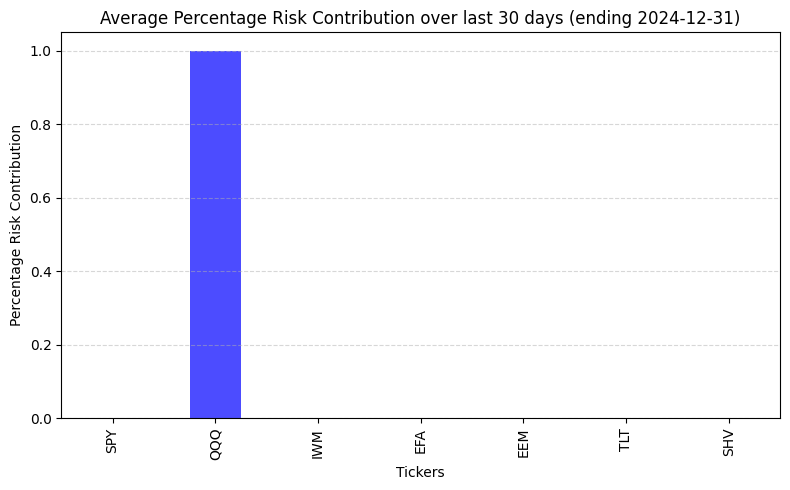

In [10]:
## Paid-subscriber Analyzer
RiskContributionAnalyzer().plot(results)

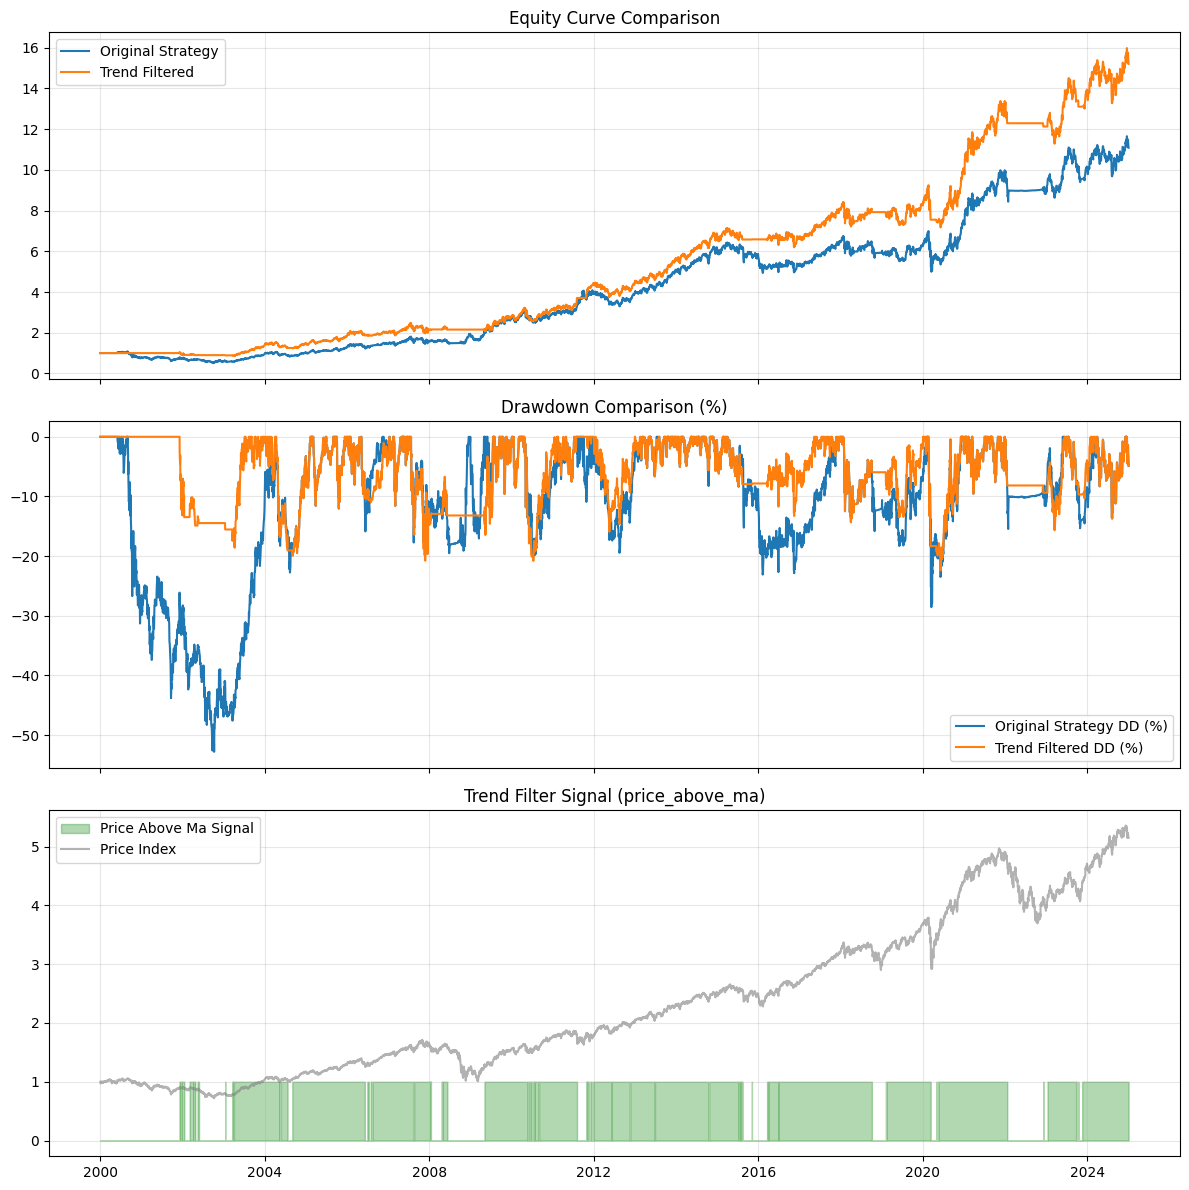


Performance Comparison:
Metric          | Original Strategy    | Trend Filtered      
------------------------------------------------------------
Total Return    | 1008.79%             | 1420.84%            
CAGR            | 10.12%               | 11.52%              
Annual Vol      | 20.49%               | 15.90%              
Sharpe Ratio    | 0.49                 | 0.72                
Max Drawdown    | -52.82%              | -22.42%             
Win Rate        | 53.24%               | 39.53%              
% Time in Market | 71.28%               | 71.28%              

Trend Filter Parameters:
- Filter Type: Price Above Ma
- Short Window: 50
- Long Window: 200


In [11]:
## Paid-subscriber Analyzer
TrendFilterAnalyzer(filter_type='price_above_ma').plot(results)

In [12]:
commodity_etfs = ["GLD", "SLV", "USO", "DBA", "TLT", "SHY"]
stocks_basket = ["AAPL", "TSLA", "XOM", "JNJ", "TLT", "BIL"]
extended_sectors = ["XLF", "XLE", "XLK", "XLY", "XLP", "XLV", "XLI", "XLB", "XLU", "TLT", "SHY"]

bonus_vanguard = ["VTI", "VEA", "VWO", "BND", "BIV", "VGSH"]
bonus_spdr_w_gold = ["SPY","MDY","SPEM","SPDW","GLD","ITE","BIL"]

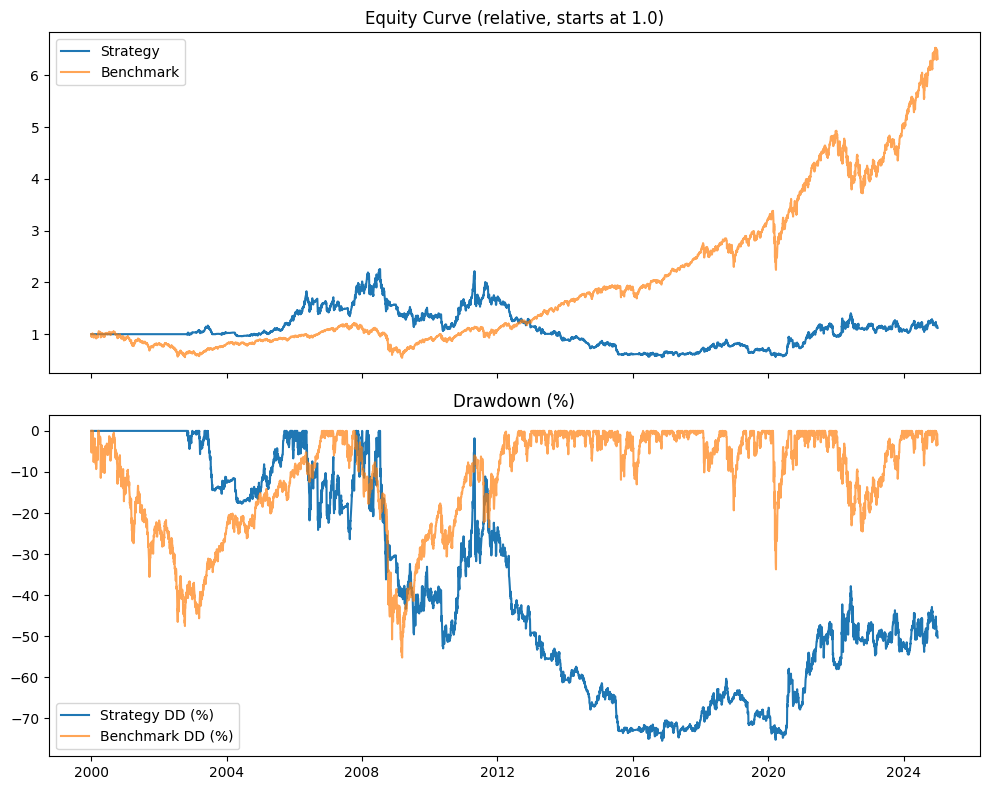

In [13]:
strategy = GlobalMarketRotationStrategy(
    tickers=commodity_etfs,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY")

EquityDrawdownAnalyzer().plot(results)

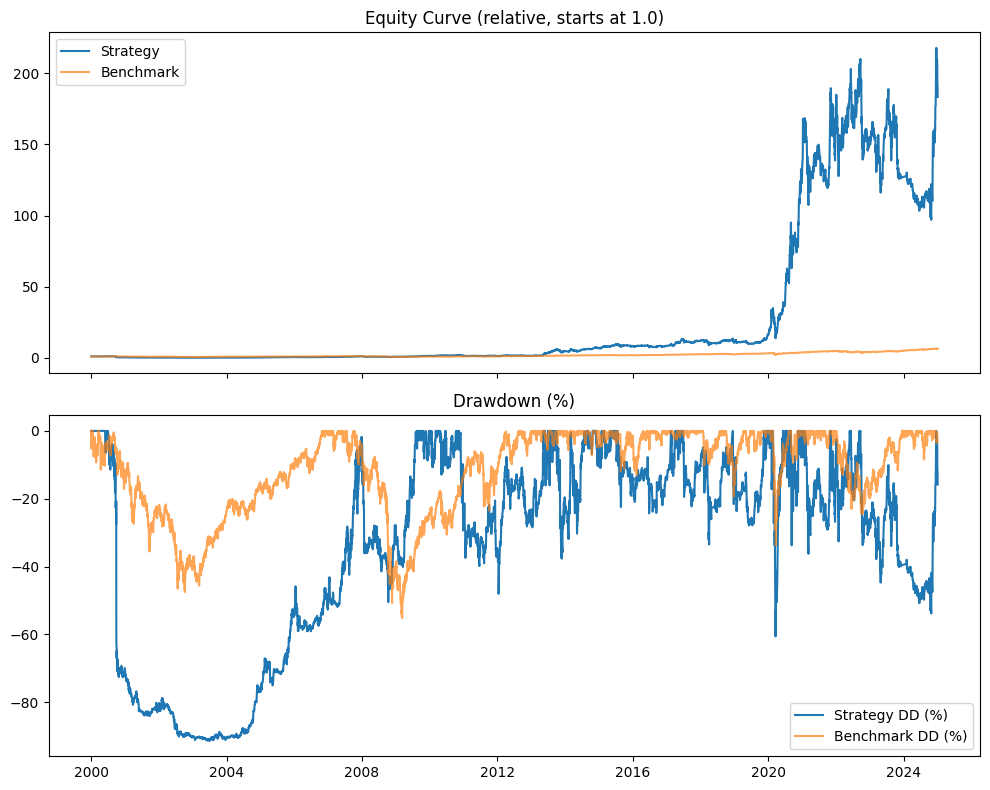

In [14]:
strategy = GlobalMarketRotationStrategy(
    tickers=stocks_basket,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY")

EquityDrawdownAnalyzer().plot(results)

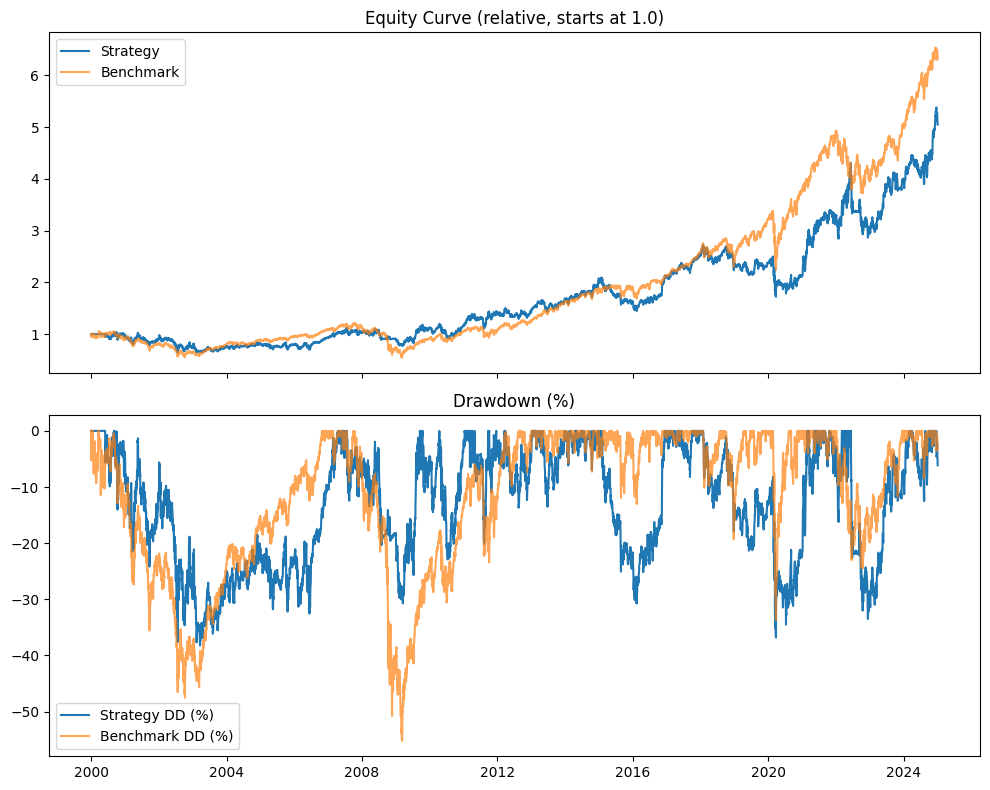

In [15]:
strategy = GlobalMarketRotationStrategy(
    tickers=extended_sectors,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY")

EquityDrawdownAnalyzer().plot(results)

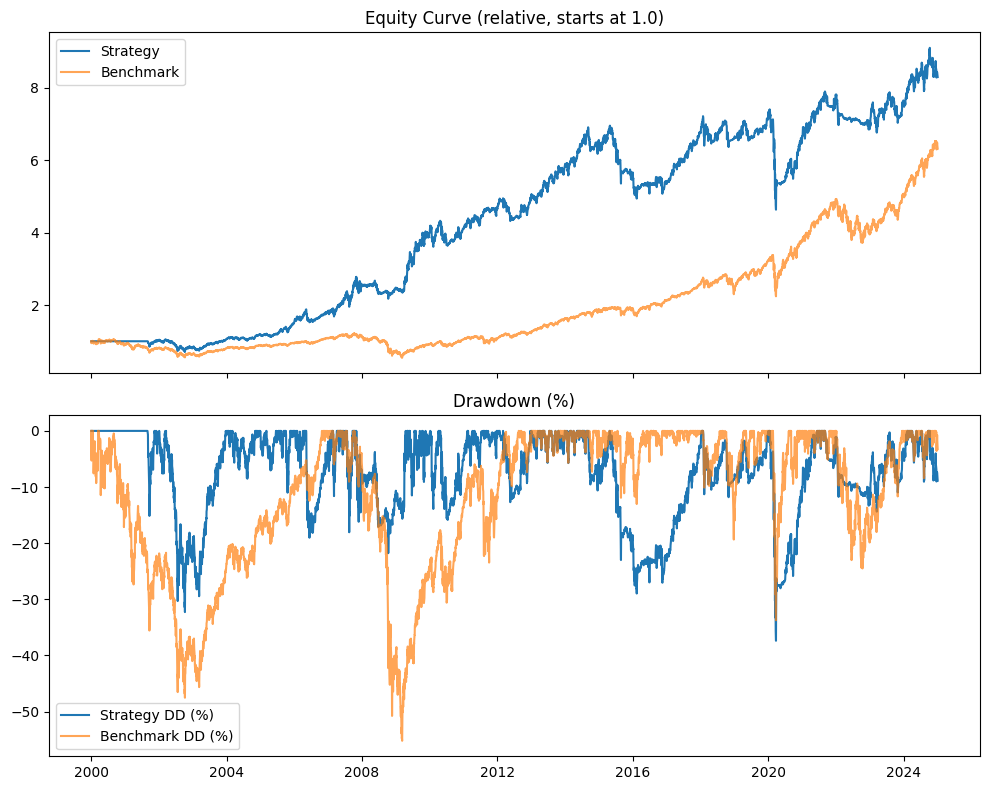

In [16]:
strategy = GlobalMarketRotationStrategy(
    tickers=bonus_vanguard,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY")

EquityDrawdownAnalyzer().plot(results)

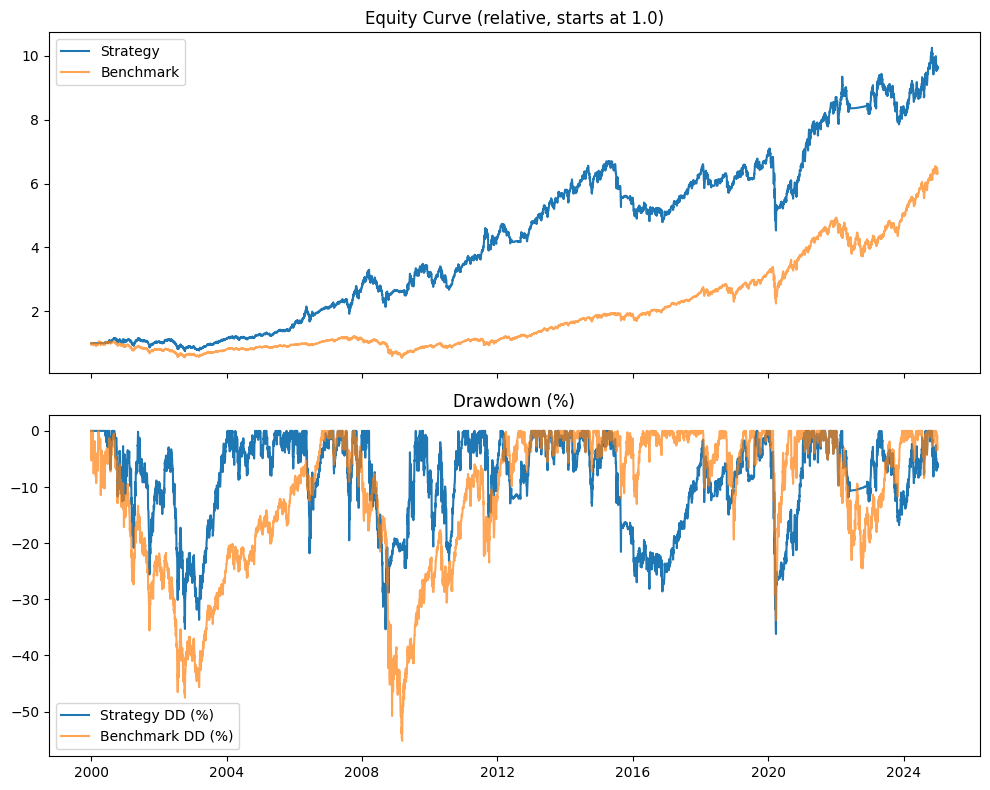

In [17]:
strategy = GlobalMarketRotationStrategy(
    tickers=bonus_spdr_w_gold,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark_ticker="SPY")

EquityDrawdownAnalyzer().plot(results)